In [29]:
from nlp import Dataset
import pandas as pd
import re
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from torch.nn import Softmax
from torch import tensor, where
from torch.utils.data import DataLoader


In [2]:
# Our same clean tweet function as before

URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')

def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

In [3]:
# read our tweet sample
tweets = pd.read_csv('../data/tweets_sample.csv', encoding='ISO-8859-1')

# convert the date to a datetime format
tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# set our index as our datetime column and delete the date columns
tweets.index = tweets['date']
del tweets['date']

# Sort our tweets
tweets.sort_index(inplace=True)

# clean our tweet text using a custom function
tweets['text'] = tweets['OriginalTweet'].apply(clean_tweet)

# Perform the same label mapping as before
tweets['labels'] = tweets['Sentiment'].map({
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Extremely Positive': 2
})

In [4]:
tweets['text'] = tweets['OriginalTweet'].apply(clean_tweet)

In [5]:
tweets['index'] = range(tweets.shape[0])

In [6]:
BERT_MODEL = 'distilbert-base-uncased'

bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL)


In [7]:
tweets = tweets[:'2020-03']

In [8]:
tweet_dataset = Dataset.from_pandas(tweets.reset_index()[['text', 'labels', 'index']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# We will pad our dataset so that our input matrices are the same length and truncate anything longer than 512 tokens
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'labels', 'index'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'labels', 'index'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [11]:
from aum import AUMCalculator

save_dir = './clean'
aum_calculator = AUMCalculator(save_dir, compressed=False)

In [12]:
from transformers import AdamW

optimizer = AdamW(sequence_classification_model.parameters(), lr=5e-5)

In [13]:
from transformers import get_scheduler

train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [14]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

sequence_classification_model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        _batch = {k: v for k, v in batch.items() if k not in ('index',)}
        outputs = sequence_classification_model(**_batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        
        records = aum_calculator.update(outputs.logits, batch['labels'], batch['index'].tolist())
        
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/340 [00:00<?, ?it/s]

In [15]:
aum_calculator.finalize()

In [16]:
aum_values = pd.read_csv('./clean/aum_values.csv')

aum_values.head()

,sample_id,aum
0,631,4.833951
1,2047,4.783761
2,856,4.759823
3,489,4.721553
4,2113,4.707543


In [17]:
aum_values.tail()

,sample_id,aum
2160,189,-2.684253
2161,1275,-3.183550
2162,2262,-3.430273
2163,1720,-3.829838
2164,2021,-3.930788


In [18]:
all_aum_records = pd.read_csv('./clean/full_aum_records.csv')
print(all_aum_records.shape)
all_aum_records.head()

(21650, 8)


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
0,3,1,0,0.045145,2,0.103130,-0.057985,-0.057985
1,3,2,0,0.488836,1,0.343246,0.145589,0.043802
2,3,3,0,2.165504,1,-0.506680,2.672184,0.919930
3,3,4,0,2.900662,2,-1.349745,4.250407,1.752549
4,3,5,0,3.197479,2,-1.443019,4.640498,2.330139


In [ ]:
950

In [33]:

all_aum_records[all_aum_records['sample_id'] == 2021]

,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
16070,2021,1,1,-0.065304,2,0.818957,-0.884260,-0.884260
16071,2021,2,1,-0.936340,2,2.034497,-2.970837,-1.927549
16072,2021,3,1,-1.373233,2,2.957131,-4.330364,-2.728487
16073,2021,4,1,-1.417986,2,3.011595,-4.429581,-3.153761
16074,2021,5,1,-1.419494,2,3.078312,-4.497806,-3.422570
16075,2021,6,1,-1.554803,2,3.293090,-4.847893,-3.660124
16076,2021,7,1,-1.279511,2,3.266360,-4.545871,-3.786659
16077,2021,8,1,-1.036999,2,3.213236,-4.250235,-3.844606
16078,2021,9,1,-1.247438,2,3.289425,-4.536863,-3.921523
16079,2021,10,1,-0.892039,2,3.122126,-4.014165,-3.930788


<AxesSubplot:>

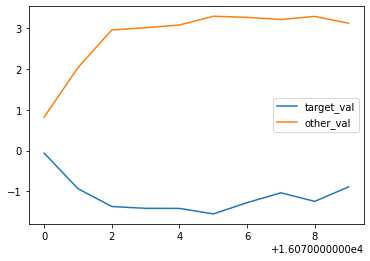

In [34]:
all_aum_records[all_aum_records['sample_id'] == 2021][['target_val', 'other_val']].plot()

In [37]:
tweets[tweets['index'] == 2021][['OriginalTweet', 'Sentiment']].values

array([['COVID-19 Consumer Rights\r\r\n\r\r\nhttps://t.co/2hwMp1zCA4\r\r\n\r\r\n#MABS #DublinSouthMABS #support #help #WeAreInThisTogether #COVID19 #COVID_19 #CoronaCrisis #MoneyAdviceÂ\x85 https://t.co/hSbYwfaW1h',
        'Neutral']], dtype=object)

In [ ]:
# Using cosine similarity to find confusing phrases

In [25]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [26]:
embeddings = model.encode(tweets['text'].tolist(), convert_to_tensor=True)

In [27]:
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

In [58]:
index1, index2 = where(cosine_scores >= 0.9)
pairs_to_consider = list(zip(index1.tolist(), index2.tolist()))
for i1, i2 in pairs_to_consider[:len(pairs_to_consider)//2]:
    if i1 != i2:
        samples = tweets[tweets['index'].isin([i1, i2])]
        if samples['Sentiment'].nunique() > 1:
            print(i1, i2, samples[['OriginalTweet', 'Sentiment']].values)
            print('--------')

21 233 [["Lowe's closes Harper Woods store to customers after employee dies of COVID-19 https://t.co/Wke3lNHRwM via @crainsdetroit"
  'Positive']
 [".@Lowe's closes Harper Woods store to customers after employee dies of #COVID19 https://t.co/MJhZQwpL4W via @crainsdetroit"
  'Neutral']]
--------
94 233 [["Lowe's closes Harper Woods store to customers after employee dies of COVID-19 https://t.co/V6Q3HYnZaE"
  'Positive']
 [".@Lowe's closes Harper Woods store to customers after employee dies of #COVID19 https://t.co/MJhZQwpL4W via @crainsdetroit"
  'Neutral']]
--------
210 304 [['Covid-19 #heroes: Â\x91The #pub may be closed but that doesnÂ\x92t mean we canÂ\x92t help peopleÂ\x92 https://t.co/RJCkmLDVt5 #coronavirus'
  'Positive']
 ['Covid-19 heroes: Â\x91The pub may be closed but that doesnÂ\x92t mean we canÂ\x92t help peopleÂ\x92\r\r\nhttps://t.co/mpq8VYPrcT #coronavirus positive mindset'
  'Extremely Positive']]
--------
233 21 [["Lowe's closes Harper Woods store to customers after emp

In [41]:
'''

990  ["Scammers are taking advantage of fears surrounding the #Coronavirus. Here's information on how to avoid being a victim of a scam.\r\r\nhttps://t.co/6o6HVGjhzw"
  'Extremely Negative']
2574 ['#Scammers are taking advantage of fears surrounding the #Coronavirus. Here are some tips to help you keep the scammers at bay:  https://t.co/fcIYjG2TjC'
  'Positive']
'''

"\n\n950  ['?????? FOR ALL THE GROCERY STORE EMPLOYEES! #COVID2019 #coronavirus #pandemic #corona', 'Neutral']\n1263 ['Grocery store employees are flippin heroes!! #coronavirus', 'Positive']\n\n"

In [59]:
# AUM says they are both just fine
aum_values[aum_values['sample_id'].isin((990, 2574))]

,sample_id,aum
137,2574,4.336185
458,990,3.987751


In [61]:
# Our model is VERY confident in it's predictions
Softmax()(sequence_classification_model(**bert_tokenizer(
    clean_tweet('#Scammers are taking advantage of fears surrounding the #Coronavirus. Here are some tips to help you keep the scammers at bay:  https://t.co/fcIYjG2TjC')
, return_tensors='pt')).logits)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_6570/1545741741.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Softmax()(sequence_classification_model(**bert_tokenizer(


tensor([[0.0031, 0.0042, 0.9927]], grad_fn=<SoftmaxBackward0>)